In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Subset, TensorDataset
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')

In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train_data.shape


(27455, 785)

In [5]:
train_data.size

21552175

In [6]:
test_data = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [7]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [8]:
test_data.shape

(7172, 785)

In [9]:
test_data.size

5630020

## Transforming the Data

In [10]:

np.unique(train_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [11]:
np.bincount(train_data["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162,    0, 1114,
       1241, 1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082,
       1225, 1164, 1118])

In [12]:
np.unique(test_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [13]:
np.bincount(test_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288,   0, 331, 209, 394,
       291, 246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

In [14]:
def adj_class_labels(label):
    """Subtracts one from the label when greater than 9."""
    if label >= 10:
        label -= 1
    return label    

In [15]:
train_data["label"] = train_data["label"].apply(adj_class_labels)

In [16]:
np.unique(train_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [17]:
np.bincount(test_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288,   0, 331, 209, 394,
       291, 246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

In [18]:
test_data["label"] = test_data["label"].apply(adj_class_labels)

In [19]:
np.unique(test_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [20]:
np.bincount(test_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288, 331, 209, 394, 291,
       246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

## Creating Datasets

In [21]:


targt = train_data["label"].values
features = train_data.drop("label", axis=1).values

In [22]:
targt_test = test_data["label"].values
features_test = test_data.drop("label", axis=1).values

In [23]:
features = features.reshape(-1, 1, 28 ,28)
features_test = features_test.reshape(-1,1, 28,28)

In [24]:
features_scaled = features / 255
features_test_scaled = features_test /255

In [25]:
y_train = torch.from_numpy(targt).float()
x_train = torch.from_numpy(features_scaled).float()

y_test = torch.from_numpy(targt_test).float()
x_test = torch.from_numpy(features_test_scaled).float()

In [26]:
sign_lang_mnist_ds = TensorDataset(x_train, y_train)

test_dataset = TensorDataset(x_test, y_test)

In [27]:
train_dataset = Subset( sign_lang_mnist_ds, torch.arange(10000, len(sign_lang_mnist_ds)))
valid_dataset = Subset(sign_lang_mnist_ds, torch.arange(10000))

In [28]:
len(train_dataset), len(valid_dataset), len(test_dataset)


(17455, 10000, 7172)

## Visualizing the data

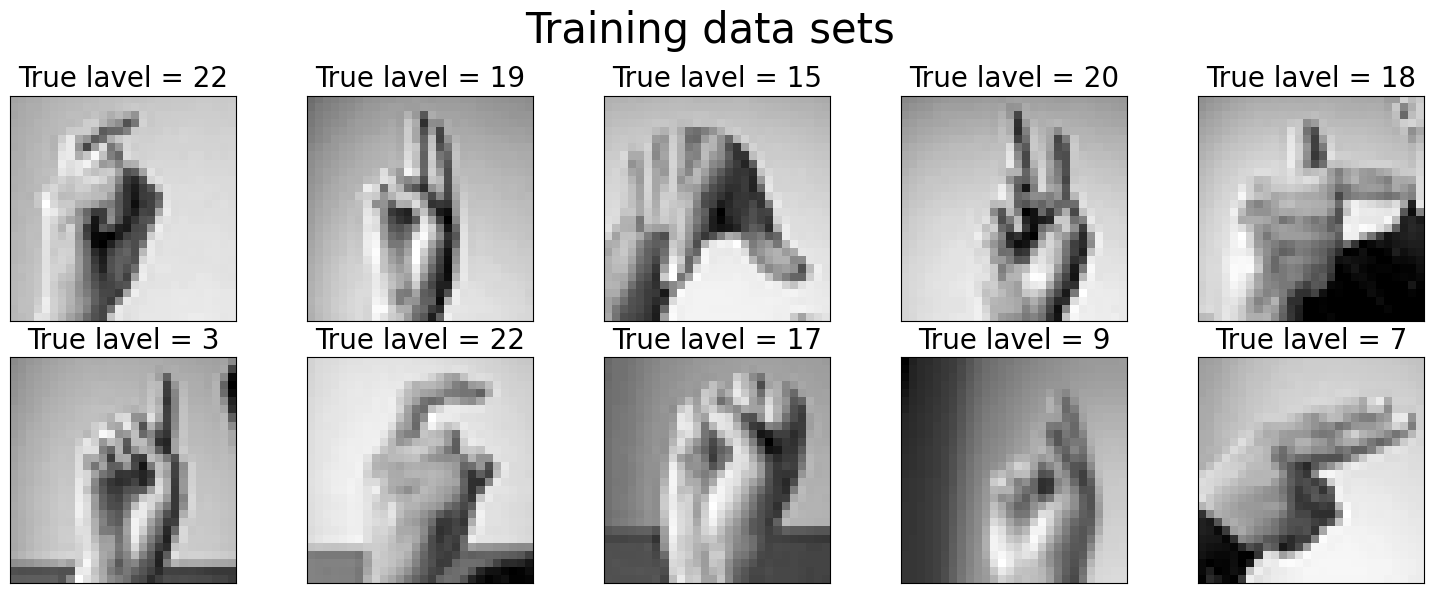

In [29]:
fig = plt.figure(figsize=(15,6))
for i, (data, label) in itertools.islice(enumerate(train_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy(). reshape(28, 28), cmap='gray')
    ax.set_title(f'True lavel = {int(label)}', size=20)
plt.suptitle("Training data sets ", fontsize=30)
plt.tight_layout()
plt.show()

    

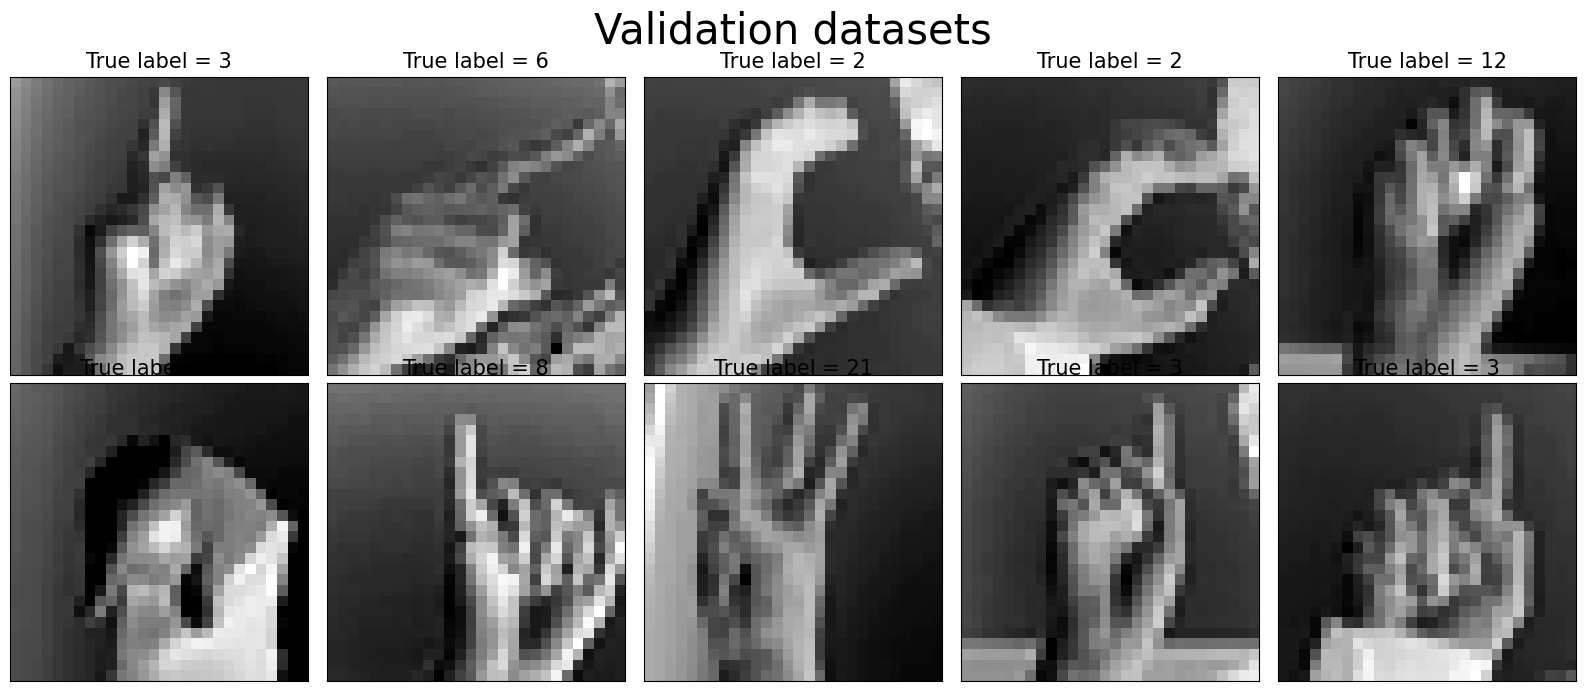

In [30]:
fig = plt.figure(figsize=(16,7))
for i, (data, label) in itertools.islice(enumerate(valid_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Validation datasets", fontsize=30)
plt.tight_layout()
plt.show()
    

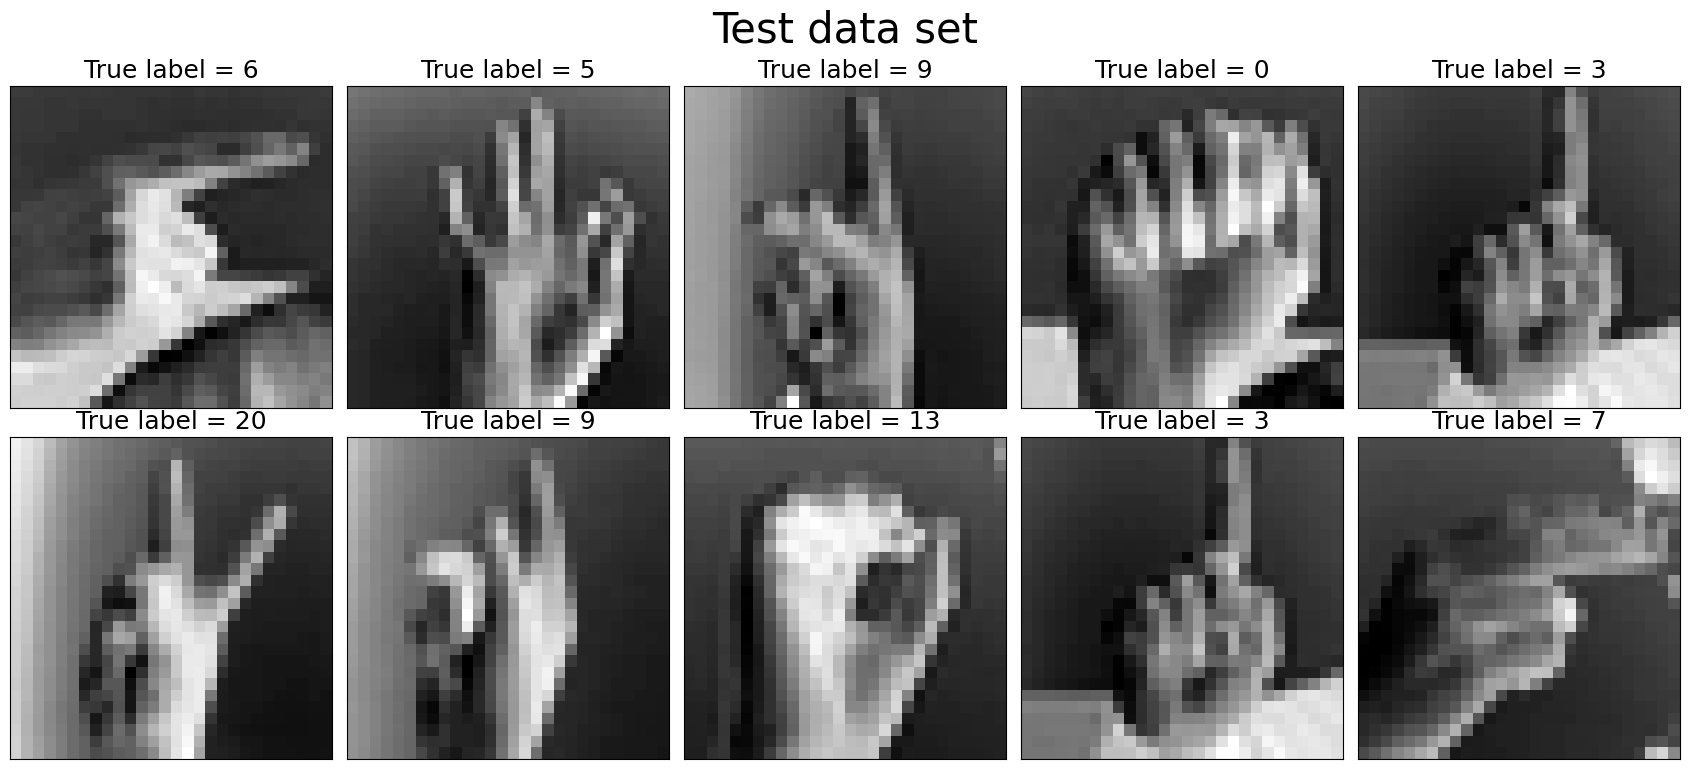

In [31]:
fig = plt.figure(figsize=(17,8))
for i, (data, label) in itertools.islice(enumerate(test_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=18)
plt.suptitle("Test data set", fontsize=30)
plt.tight_layout()
plt.show()

### Plotting class labels shares

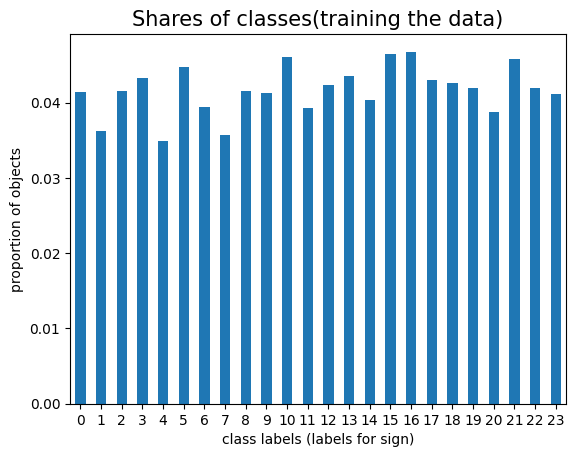

In [32]:
train_labels = train_dataset[:][1].int()
unq_train_labels = np.unique(train_labels)
train_labels_count = np.bincount(train_labels)
no_train = train_labels.shape[0]
label_info_share = pd.Series(train_labels_count, index=unq_train_labels)/no_train

label_info_share.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Shares of classes(training the data)", fontsize=15)
plt.xlabel("class labels (labels for sign)")
plt.ylabel("proportion of objects")
plt.show()

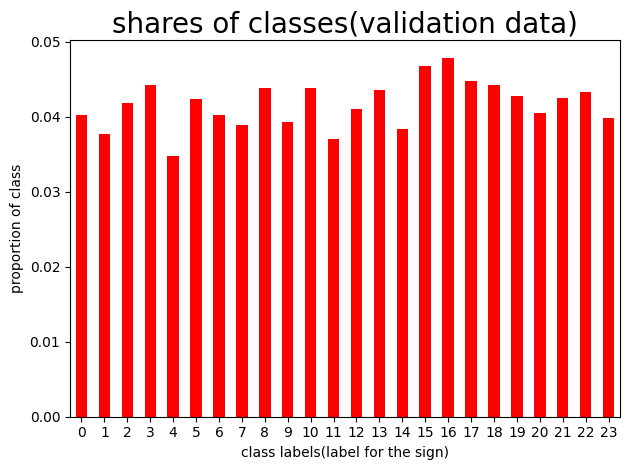

In [33]:
valid_labels = valid_dataset[:][1].int()
unq_valid_labels = np.unique(valid_labels)
valid_labels_count = np.bincount(valid_labels)
n_valid = valid_labels.shape[0]
labels_info_share = pd.Series(valid_labels_count, index = unq_valid_labels)/n_valid
labels_info_share.plot(kind="bar", color="red")
plt.xticks(rotation=0)
plt.title("shares of classes(validation data)", fontsize=20)
plt.xlabel("class labels(label for the sign)")
plt.ylabel("proportion of class")
plt.tight_layout()
plt.show()

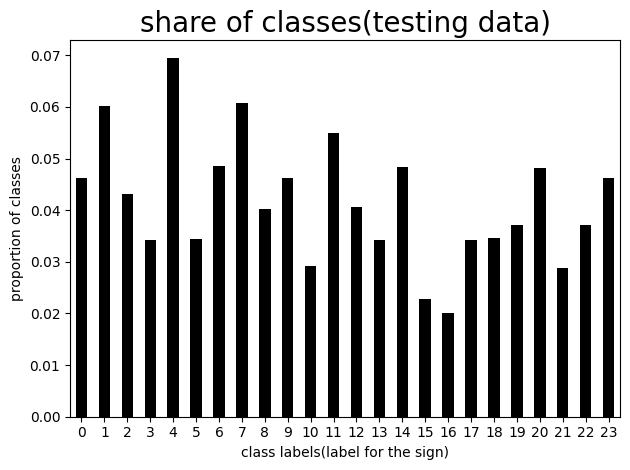

In [34]:
test_labels = test_dataset[:][1].int()
unq_testing_labels = np.unique(test_labels)
test_labels_count = np.bincount(test_labels)
n_test = test_labels.shape[0]
labels_info_share = pd.Series(test_labels_count, index = unq_testing_labels)/n_test
labels_info_share.plot(kind = "bar", color="black")
plt.xticks(rotation=0)
plt.title("share of classes(testing data)", fontsize=20)
plt.xlabel("class labels(label for the sign)")
plt.ylabel("proportion of classes")
plt.tight_layout()
plt.show()

### Creating the data loaders

In [35]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
)

### Now Lets build a CNN!

In [36]:
sign_mnist_classifier = nn.Sequential()
#convolutional layer 1
sign_mnist_classifier.add_module(
    "conv1",
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
# activation of convolutional layer 1
sign_mnist_classifier.add_module("relu1", nn.ReLU())
#max_pooling layer 1
sign_mnist_classifier.add_module("pool1", nn.MaxPool2d(kernel_size=2))

#convolutional layer 2
sign_mnist_classifier.add_module(
    "conv2",
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))

#activation of convolutional layer 2
sign_mnist_classifier.add_module("relu2", nn.ReLU())

#max pooling layer 2
sign_mnist_classifier.add_module("pool2", nn.MaxPool2d(kernel_size=2))

#flatten layer
sign_mnist_classifier.add_module("flatten", nn.Flatten())

#fully connected layer 1
sign_mnist_classifier.add_module('fc1', nn.Linear(3136, 1024))

#activation for fully connected layer #1
sign_mnist_classifier.add_module('relu3',nn.ReLU())

#dropout
sign_mnist_classifier.add_module('dropout', nn.Dropout(p=0.5))

#fully connected layer #2
sign_mnist_classifier.add_module('fc2', nn.Linear(1024, 24))



In [37]:
sign_mnist_classifier.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=24, bias=True)
)

### training and validation loop

In [46]:
def train (
    model,
    loss_func,
    optimizer,
    train_dataloader,
    valid_dataloader,
    epochs=10,
    enable_logging=False,
    device=DEVICE,
):
    """trains the neural net."""
    
    #preallocating arrays for the losses and accuracies
    loss_history_train = [0] * epochs
    accuracy_history_train = [0] * epochs
    loss_history_valid = [0] * epochs
    accuracy_history_valid = [0] * epochs
    
    #launching the algorithm
    for epoch in range(epochs):
        model.train()  #enabling training mode
        
    
     
    #considering each batch for current epoch
    for x_batch, y_batch in train_dataloader:
        #moving data to the gpu
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        #generating predictions for batch 
        model_predictions = model(x_batch)
        
        #computing loss
        
        loss = loss_func(model_predictions, y_batch.long())
        
        #computing the gradients
        
        loss.backward()
        
        #updating parameters using the gradients
        optimizer.step()
        
        #resetting gradients to zero
        optimizer.zero_grad()
        
        #adding the batch level of loss and accuracy to the history 
        loss_history_train[epoch] += loss.item() * y_batch.size(0)
        is_correct = (
            torch.argmax(model_predictions, dim=1) == y_batch).float()
        accuracy_history_train[epoch] += is_correct.sum().cpu()
        
    #computing the epoch level loss and accuracy
    loss_history_train[epoch] /= len(train_dataloader.dataset)
    accuracy_history_train[epoch] /= len(train_dataloader.dataset)
    
    #enabling evaluation mode
    model.eval()
    
    #testing the CNN on the validation set
    
    with torch.no_grad():
        for x_batch, y_batch in valid_dataloader:
            #moving the data to gpu
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # generating the predictions for batch
            model_predictions = model(x_batch)
            
            #computing the loss
            loss = loss_func(model_predictions, y_batch.long())
            
            #adding batch level loss and accuracy to the history 
            
            loss_history_valid[epoch] += loss.item() * y_batch.size(0)
            
            is_correct = (
                torch.argmax(model_predictions, dim=1) == y_batch
            ).float()    
            accuracy_history_valid[epoch] += is_correct.sum().cpu()
            
    #computing the epoch-leveling loss and accuracy 
    loss_history_valid[epoch] /= len(valid_dataloader.dataset)
    accuracy_history_valid[epoch] /= len(valid_dataloader.dataset)
    
    # logging training process
    if enable_logging:
        print(
            "Epoch {}/{}\n"
             "train_loss = {:.4f}, train_accuracy = {:.4f} |"
             "valid_loss = {:.4f}, valid_accuracy = {:.4f}".format(
            epoch + 1,
            epochs,
            loss_history_train[epoch],
            accuracy_history_train[epoch],
            loss_history_valid[epoch],
            accuracy_history_valid[epoch],
            )
        )
    return (
   model,
   loss_history_train,
   accuracy_history_train,
   loss_history_train,
   accuracy_history_valid,
)

In [47]:
sign_mnist_classifier = sign_mnist_classifier.to(DEVICE)

## Now Training the CNN

In [48]:
#defining loss function (multiclass classification)
loss_func = nn.CrossEntropyLoss()
# defining the learning rate
learning_rate = 0.001

#defining optimizer 
optimizer = torch.optim.Adam(
    sign_mnist_classifier.parameters(), lr=learning_rate)

In [49]:
#setting the random seed

torch.manual_seed(RANDOM_SEED)

#training CNN
(
sign_mnist_classifier,
loss_history_train,
accuracy_history_train,
loss_history_valid,
accuracy_history_valid
) = train(
    model = sign_mnist_classifier,
    loss_func = loss_func,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader,
    epochs = 8,
    enable_logging = True,
)

Epoch 8/8
train_loss = 1.2886, train_accuracy = 0.6041 |valid_loss = 0.2887, valid_accuracy = 0.9315


## now plotting training/validation loss

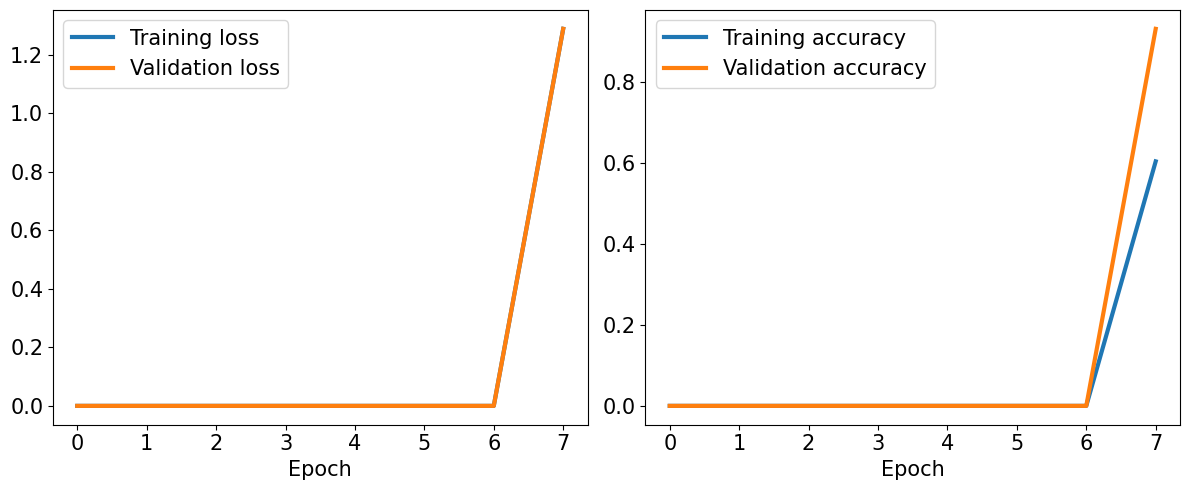

In [50]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history_train, lw=3)
ax.plot(loss_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training loss', 'Validation loss'], fontsize=15)

# plotting the training/validation accuracy

ax=fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history_train, lw=3)
ax.plot(accuracy_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)

plt.tight_layout()
plt.show()

### making the test predictions



In [51]:
def evaluate_test_by_batch(model, testing_dataloader, device=DEVICE):
    """computes predictions and accuracy for the dataloader."""
    
    #initializing counter for accuracy
    accuracy_test = 0
    #initializing list for storing predictions
    test_predictions = []
    #setting model to the evaluation model
    model.eval()
    #computing accuracy and predictions
    with torch.no_grad():
        for x_batch, y_batch in testing_dataloader:
            #moving data to the gpu
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            #computing the predictions for batch
            test_batch_predictions = torch.argmax(model(x_batch), dim=1)
            #adding batch predictions to prediction list
            test_predictions.append(test_batch_predictions)
            #computing test accuracy
            is_correct = (test_batch_predictions == y_batch). float()
            accuracy_test += is_correct.sum().cpu()
            
    # transforming list of tensors into one of tensor
    test_predictions_tensor = torch.cat(test_predictions).cpu()
    #finishing computing testing accuracy
    accuracy_test /= len(test_dataloader.dataset)
    
    return accuracy_test, test_predictions_tensor

In [52]:
accuracy_test, predictions_test = evaluate_test_by_batch(model = sign_mnist_classifier, testing_dataloader = test_dataloader)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.8511


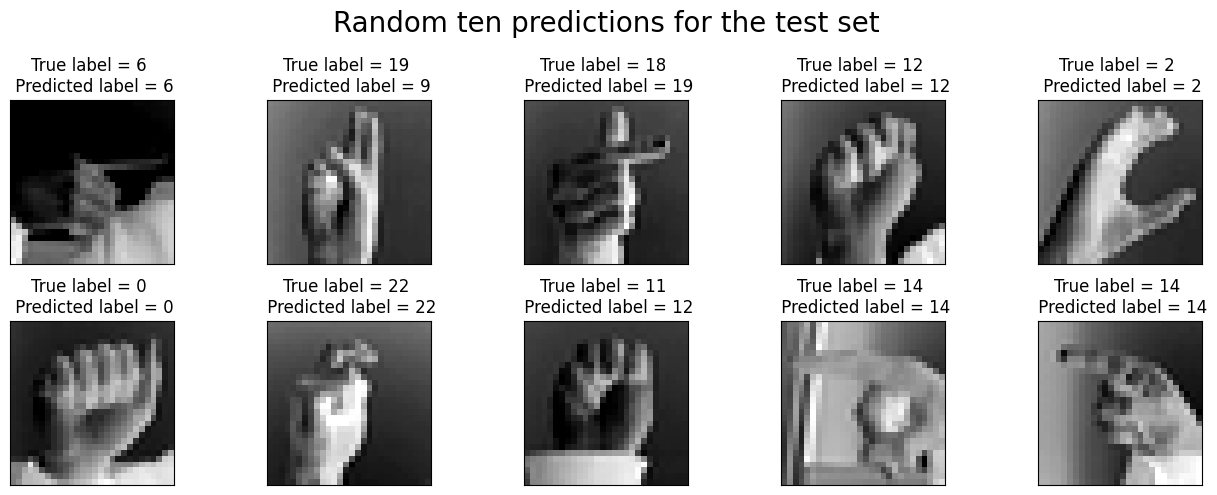

In [58]:
num = np.random.randint(low=0, high=x_test.shape[0], size=10)
fig = plt.figure(figsize=(13,5))
for i, num in enumerate(num):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_test[num].numpy().reshape(28, 28), cmap="gray_r")
    ax.set_title(f"True label = {y_test[num].int()} \n Predicted label = {predictions_test[num]}")
plt.suptitle("Random ten predictions for the test set", fontsize=20)
plt.tight_layout()
plt.show()

In [61]:
target_names =  [
    "A", "B", "C", "D", "E", "F",
    "G", "H", "I", "K", "L", "M",
    "N", "O", "P", "Q", "R", "S",
    "T", "U", "V", "W", "X", "Y",
]

print(classification_report(
    y_true = y_test,
    y_pred = predictions_test,
    target_names = target_names,
)
     )

              precision    recall  f1-score   support

           A       0.86      0.99      0.92       331
           B       1.00      0.99      0.99       432
           C       1.00      0.99      1.00       310
           D       0.89      0.84      0.86       245
           E       0.94      0.87      0.90       498
           F       1.00      1.00      1.00       247
           G       0.90      0.90      0.90       348
           H       0.89      0.95      0.92       436
           I       0.95      0.85      0.90       288
           K       0.76      0.94      0.84       331
           L       1.00      1.00      1.00       209
           M       0.83      0.39      0.53       394
           N       0.56      0.73      0.64       291
           O       1.00      0.78      0.88       246
           P       0.98      0.94      0.96       347
           Q       0.82      0.91      0.86       164
           R       0.68      0.78      0.73       144
           S       0.45    